"""
==============================================================================
03 - CNN-LSTM ADVANCED MODEL
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Train and evaluate a CNN-LSTM neural network for price direction prediction.

This is our ADVANCED model because:
1. CNN layers capture local patterns (like candlestick patterns)
2. LSTM layers capture temporal dependencies (memory of past states)
3. Combination is powerful for sequential financial data

WHY CNN + LSTM?
---------------
- CNN: Good at finding local patterns in data (like chart patterns)
- LSTM: Good at remembering long-term dependencies
- Together: Can learn complex temporal patterns in price movements

EXPECTED RESULTS:
-----------------
- Neural networks often match or slightly beat tree-based models
- Main advantage: Can learn non-linear patterns automatically
- Main disadvantage: Slower training, needs more data

"""

# CNN-LSTM Advanced Model

**Goal**: Train a deep learning model that can capture temporal patterns.

**Architecture**:
1. Input: Sequence of N past feature vectors (lookback window)
2. Conv1D: Extract local patterns
3. LSTM: Capture temporal dependencies
4. Dense: Classification into UP/SIDEWAYS/DOWN

In [1]:
# ==============================================================================
# IMPORTS AND GPU CHECK
# ==============================================================================
#
# TensorFlow/Keras is used for the neural network.
# We check for GPU availability because training is MUCH faster on GPU.

import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# GPU AVAILABILITY CHECK
# ==============================================================================
# Neural networks are 10-100x faster on GPU compared to CPU.
# If no GPU is detected, training will still work but be slower.

print("="*60)
print("🖥️ SYSTEM CHECK")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {gpus[0].name}")
    print("   Training will be fast!")
else:
    print("⚠️ No GPU detected - training will be slower")
    print("   Consider using Google Colab for faster training")

2026-01-22 10:07:27.471492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 10:07:27.547742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 10:07:36.584592: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🖥️ SYSTEM CHECK
TensorFlow version: 2.20.0
✅ GPU available: /physical_device:GPU:0
   Training will be fast!


In [2]:
# ==============================================================================
# IMPORT PROJECT MODULES
# ==============================================================================

# Reload modules to pick up any code changes without restarting kernel
import importlib
import src.data.loader
import src.labeling.oracle
import src.features.builder
import src.features.indicators
import src.models.cnn_lstm
importlib.reload(src.data.loader)
importlib.reload(src.labeling.oracle)
importlib.reload(src.features.builder)
importlib.reload(src.features.indicators)
importlib.reload(src.models.cnn_lstm)

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.cnn_lstm import CNNLSTMModel

## 1. Configuration

**NEW PARAMETER - LOOKBACK:**

Unlike XGBoost which sees one row at a time, CNN-LSTM sees a SEQUENCE of rows.
`LOOKBACK=20` means the model sees the last 20 candles (5 hours for 15-min data).

This allows the model to learn patterns like:
- "Price usually reverses after 3 consecutive red candles"
- "High volume followed by low volume often precedes breakouts"

In [3]:
# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================

# Oracle label parameters (same as baseline for fair comparison)
SIGMA = 4           # Gaussian smoothing sigma
THRESHOLD = 0.0001  # Slope threshold for direction classification

# Prediction horizon
HORIZON = 1         # Predict next bar direction

# CNN-LSTM specific parameter
LOOKBACK = 20       # How many past candles to look at
                    # 20 candles × 15 min = 5 hours of history
                    # Experiment with: 5, 10, 20, 30, 50

# Train/Test split dates
TRAIN_END = "2025-06-30"
TEST_START = "2025-07-01"

print("="*60)
print("📋 CONFIGURATION")
print("="*60)
print(f"Oracle: sigma={SIGMA}, threshold={THRESHOLD}")
print(f"Prediction Horizon: {HORIZON} bar(s)")
print(f"Lookback Window: {LOOKBACK} candles ({LOOKBACK * 15} minutes)")
print(f"Training: up to {TRAIN_END}")
print(f"Testing: from {TEST_START}")

📋 CONFIGURATION
Oracle: sigma=4, threshold=0.0001
Prediction Horizon: 1 bar(s)
Lookback Window: 20 candles (300 minutes)
Training: up to 2025-06-30
Testing: from 2025-07-01


## 2. Load and Prepare Data

Same data loading as baseline for fair comparison.

In [4]:
# ==============================================================================
# LOAD DATA AND CREATE LABELS
# ==============================================================================

print("\n" + "="*60)
print("📥 LOADING DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
df = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print(f"\n✅ Loaded {len(df):,} rows")
print("\nLabel distribution:")
label_counts = df['target'].value_counts(normalize=True).sort_index()
label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
for label, pct in label_counts.items():
    print(f"  {label_names[label]:8s}: {pct*100:5.1f}%")


📥 LOADING DATA

📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

✅ Loaded 70,081 rows

Label distribution:
  DOWN    :  37.8%
  SIDEWAYS:  20.7%
  UP      :  41.5%


In [5]:
# ==============================================================================
# GENERATE FEATURES
# ==============================================================================
#
# For neural networks, we use fewer feature groups to avoid overfitting.
# Deep learning can learn features automatically, so we don't need as many.

print("\n" + "="*60)
print("⚙️ GENERATING FEATURES")
print("="*60)

# Use fewer groups for neural network (less prone to overfitting)
feature_groups = ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']
df_features, group_map = prepare_features(df, groups=feature_groups, horizon=HORIZON)

print("\nFeature groups used:")
for group, cols in group_map.items():
    print(f"  {group}: {len(cols)} features")


⚙️ GENERATING FEATURES

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: CCI_14_0.015, WILLR_14, ROC_12, UO_7_14_28, STOCHd_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: TEMA_9, SMA_200, EMA_100, EMA_10, HMA_9...
  -> Processing group: trend
     Added 17 features: CKSPs_10_3_20, AROONOSC_14, VTXM_14, TRIX_30_9, CKSPl_10_3_20...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN

In [6]:
# ==============================================================================
# TIME-BASED SPLIT
# ==============================================================================

print("\n" + "="*60)
print("📊 SPLITTING DATA")
print("="*60)

train_df, val_df, test_df = split_data_by_time(
    df_features,
    train_end=TRAIN_END,
    test_start=TEST_START,
    val_ratio=0.1  # 10% for validation (neural nets need more validation data)
)

feature_cols = get_indicator_columns(
    df_features, 
    exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in train_df.columns]
print(f"\n✅ Features: {len(feature_cols)}")


📊 SPLITTING DATA

📊 Data Split:
   Train: 44,339 rows (2024-01-03 15:30:00+00:00 to 2025-04-09 12:00:00+00:00)
   Val:   7,824 rows (2025-04-09 12:15:00+00:00 to 2025-06-30 00:00:00+00:00)
   Test:  17,568 rows (2025-07-01 00:00:00+00:00 to 2025-12-30 23:45:00+00:00)

✅ Features: 62


In [7]:
# ==============================================================================
# EXTRACT FEATURE MATRICES
# ==============================================================================
#
# Note: The CNN-LSTM model will internally convert these 2D arrays
# to 3D sequences using the LOOKBACK parameter.
# Shape: (samples, features) → (samples, lookback, features)

print("\n" + "="*60)
print("📐 EXTRACTING FEATURE MATRICES")
print("="*60)

X_train = train_df[feature_cols].values
y_train = train_df['target'].values.astype(int)

X_val = val_df[feature_cols].values
y_val = val_df['target'].values.astype(int)

X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

# Clean inf/nan values (some indicators like EOM produce inf from division by zero)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Training:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Validation: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f"Test:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

print(f"\n💡 After sequence creation (lookback={LOOKBACK}):")
print(f"   Input shape will be: (samples, {LOOKBACK}, {X_train.shape[1]})")


📐 EXTRACTING FEATURE MATRICES
Training:   44,339 samples × 62 features
Validation: 7,824 samples × 62 features
Test:       17,568 samples × 62 features

💡 After sequence creation (lookback=20):
   Input shape will be: (samples, 20, 62)


## 3. Train CNN-LSTM Model

**MODEL ARCHITECTURE:**

```
Input (lookback × features)
    ↓
Conv1D (extract local patterns)
    ↓
MaxPooling (reduce dimensionality)
    ↓
LSTM (capture temporal dependencies)
    ↓
Dropout (prevent overfitting)
    ↓
Dense (classification)
    ↓
Output (3 classes)
```

**Key Parameters:**
- `conv_filters`: Number of 1D convolution filters
- `lstm_units`: LSTM hidden state size
- `dropout`: Fraction of units to drop (regularization)
- `learning_rate`: Step size for optimizer

In [8]:
# ==============================================================================
# CREATE AND CONFIGURE MODEL
# ==============================================================================

print("\n" + "="*60)
print("🏗️ CREATING CNN-LSTM MODEL")
print("="*60)

model = CNNLSTMModel(
    n_classes=3,         # DOWN=0, SIDEWAYS=1, UP=2
    lookback=LOOKBACK,   # Sequence length (20 candles)
    conv_filters=32,     # Number of 1D convolution filters
    lstm_units=64,       # LSTM hidden state size
    dropout=0.2,         # 50% dropout for regularization
    dense_units=32,      # Dense layer before output
    learning_rate=0.001, # Adam optimizer learning rate
    device='cuda',       # Use GPU if available
    random_seed=42       # For reproducibility
)

print(f"\n✅ Model created with architecture:")
print(f"   Input:  ({LOOKBACK}, {len(feature_cols)})")
print(f"   Conv1D: {32} filters, kernel_size=3")
print(f"   LSTM:   {64} units")
print(f"   Dense:  {32} units")
print(f"   Output: 3 classes (softmax)")


🏗️ CREATING CNN-LSTM MODEL
🚀 GPU detected: /physical_device:GPU:0

✅ Model created with architecture:
   Input:  (20, 62)
   Conv1D: 16 filters, kernel_size=3
   LSTM:   64 units
   Dense:  32 units
   Output: 3 classes (softmax)


In [9]:
# ==============================================================================
# TRAIN THE MODEL
# ==============================================================================
#
# Training uses:
# - Early stopping: Stop if validation loss doesn't improve for 'patience' epochs
# - Adam optimizer: Adaptive learning rate
# - Categorical cross-entropy loss: Standard for multi-class classification
#
# This may take several minutes depending on hardware.

print("\n" + "="*60)
print("🚀 TRAINING MODEL")
print("="*60)
print("This may take several minutes...\n")

model.fit(
    X_train, y_train,
    X_val, y_val,
    feature_names=feature_cols,
    epochs=100,       # Maximum epochs (early stopping will likely end sooner)
    batch_size=64,    # Samples per gradient update
    patience=15       # Stop if no improvement for 15 epochs
)

print("\n✅ Training complete!")


🚀 TRAINING MODEL
This may take several minutes...


📊 Preparing data...
📊 Creating sequences (lookback=20)...
   Train sequences: (44319, 20, 62)
   Val sequences: (7804, 20, 62)

🏗️ Building model...


I0000 00:00:1769058467.120620   19782 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 20, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 20, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 100 epochs (patience=15)...
Epoch 1/100


2026-01-22 10:07:49.890454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


693/693 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5167 - loss: 0.9854 - val_accuracy: 0.5320 - val_loss: 0.9741 - learning_rate: 0.0010
Epoch 2/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5598 - loss: 0.9468 - val_accuracy: 0.5492 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 3/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5669 - loss: 0.9364 - val_accuracy: 0.5538 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 4/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5682 - loss: 0.9314 - val_accuracy: 0.5551 - val_loss: 0.9485 - learning_rate: 0.0010
Epoch 5/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5704 - loss: 0.9286 - val_accuracy: 0.5507 - val_loss: 0.9535 - learning_rate: 0.0010
Epoch 6/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5721 - loss: 0.9240 - val_accuracy: 0.5469 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 7/100
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5749 - loss: 0

## 4. Training History Visualization

**WHY VISUALIZE TRAINING?**

The training curves tell us:
- Is the model learning? (loss decreasing)
- Is it overfitting? (train loss << val loss)
- When did it stop improving? (early stopping point)

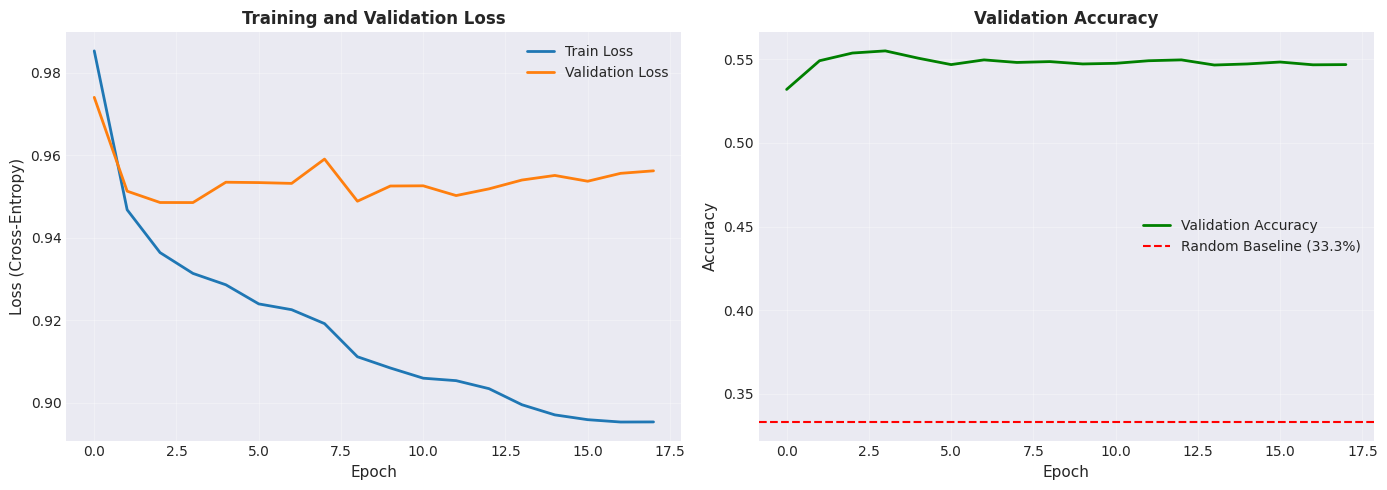


💡 TRAINING ANALYSIS:
   Final train loss: 0.8953
   Final val loss:   0.9563
   ✅ Curves are close - model is not overfitting


In [10]:
# ==============================================================================
# PLOT TRAINING HISTORY
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
# Good sign: Both curves decreasing, staying close together
# Bad sign: Train loss much lower than val loss (overfitting)
axes[0].plot(model.history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(model.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (Cross-Entropy)', fontsize=11)
axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curve
# Good sign: Accuracy increasing and stabilizing
axes[1].plot(model.history['val_acc'], label='Validation Accuracy', 
             linewidth=2, color='green')
axes[1].axhline(y=0.333, color='red', linestyle='--', label='Random Baseline (33.3%)')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze training
final_train_loss = model.history['train_loss'][-1]
final_val_loss = model.history['val_loss'][-1]
print("\n💡 TRAINING ANALYSIS:")
print(f"   Final train loss: {final_train_loss:.4f}")
print(f"   Final val loss:   {final_val_loss:.4f}")
if final_val_loss > final_train_loss * 1.5:
    print("   ⚠️ Gap suggests some overfitting - consider more dropout")
else:
    print("   ✅ Curves are close - model is not overfitting")

## 5. Evaluation on Test Set

In [11]:
# ==============================================================================
# FINAL EVALUATION
# ==============================================================================

print("\n" + "="*60)
print("🎯 TEST SET EVALUATION")
print("="*60)

test_metrics = model.evaluate(X_test, y_test)

print(f"\nTest Set Results:")
print(f"  Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})")
print(f"  F1 Weighted: {test_metrics['f1_weighted']:.4f}")
print(f"  F1 Macro:    {test_metrics['f1_macro']:.4f}")

print(f"\n  Random Baseline: 33.3%")
print(f"  Improvement:     {(test_metrics['accuracy'] - 0.333)*100:+.1f}%")


🎯 TEST SET EVALUATION

Test Set Results:
  Accuracy:    0.5495 (55.0%)
  F1 Weighted: 0.5188
  F1 Macro:    0.4881

  Random Baseline: 33.3%
  Improvement:     +21.7%


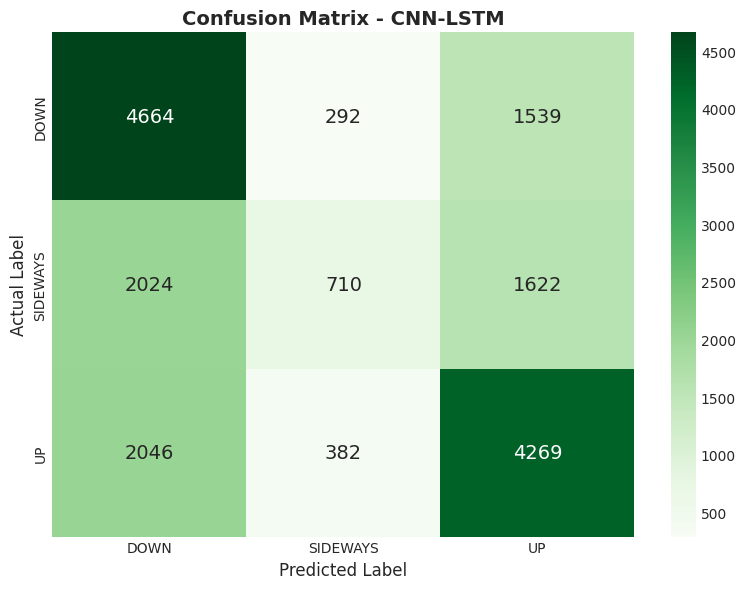

In [12]:
# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================

fig, ax = plt.subplots(figsize=(8, 6))

cm = np.array(test_metrics['confusion_matrix'])
labels = ['DOWN', 'SIDEWAYS', 'UP']

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"size": 14})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title('Confusion Matrix - CNN-LSTM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('cnn_lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# ==============================================================================
# SAVE MODEL
# ==============================================================================

print("\n" + "="*60)
print("💾 SAVING MODEL")
print("="*60)

Path('models_artifacts').mkdir(exist_ok=True)
model.save('models_artifacts', name=f'cnn_lstm_h{HORIZON}')
print(f"✅ Model saved: models_artifacts/cnn_lstm_h{HORIZON}_model.keras")


💾 SAVING MODEL
✅ Model saved to models_artifacts
✅ Model saved: models_artifacts/cnn_lstm_h1_model.keras


## 6. Hyperparameter Experiments

**WHY EXPERIMENT WITH LOOKBACK?**

The lookback window is one of the most important hyperparameters:
- Too short: Model can't see enough history
- Too long: Model may overfit to noise

We test several values to find the optimal one.

In [14]:
# ==============================================================================
# LOOKBACK EXPERIMENT
# ==============================================================================
#
# Test different lookback values to find optimal sequence length.
# This takes a while as we train multiple models.

print("\n" + "="*60)
print("🔬 LOOKBACK EXPERIMENTS")
print("="*60)
print("Testing different lookback values...")
print("This will train 4 models and may take 10-15 minutes.\n")

lookback_values = [5, 10, 20, 30]
lookback_results = []

for lb in lookback_values:
    print(f"\n--- Testing lookback={lb} ({lb * 15} minutes of history) ---")
    
    model_exp = CNNLSTMModel(
        n_classes=3,
        lookback=lb,
        conv_filters=32,
        lstm_units=64,
        dropout=0.2,
        device='cuda',
        random_seed=42
    )
    
    # Train with fewer epochs for experiments
    model_exp.fit(
        X_train, y_train, 
        X_val, y_val,
        epochs=50,       # Fewer epochs for speed
        batch_size=64, 
        patience=10,
        scale=True
    )
    
    metrics = model_exp.evaluate(X_test, y_test)
    
    lookback_results.append({
        'lookback': lb,
        'minutes': lb * 15,
        'accuracy': metrics['accuracy'],
        'f1_weighted': metrics['f1_weighted']
    })
    
    print(f"   Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_weighted']:.4f}")

# Display results
print("\n" + "="*60)
print("📊 LOOKBACK COMPARISON RESULTS")
print("="*60)

results_df = pd.DataFrame(lookback_results)
print("\n" + results_df.to_string(index=False))

# Find best
best_idx = results_df['accuracy'].idxmax()
best_lookback = results_df.loc[best_idx, 'lookback']
print(f"\n✅ Best lookback: {best_lookback} candles ({best_lookback * 15} minutes)")


🔬 LOOKBACK EXPERIMENTS
Testing different lookback values...
This will train 4 models and may take 10-15 minutes.


--- Testing lookback=5 (75 minutes of history) ---
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=5)...
   Train sequences: (44334, 5, 62)
   Val sequences: (7819, 5, 62)

🏗️ Building model...


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5, 62)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 16)          │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 5, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 5, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 5, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5109 - loss: 0.9935 - val_accuracy: 0.5502 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5536 - loss: 0.9554 - val_accuracy: 0.5455 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5607 - loss: 0.9466 - val_accuracy: 0.5530 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5635 - loss: 0.9400 - val_accuracy: 0.5479 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5671 - loss: 0.9367 - val_accuracy: 0.5524 - val_loss: 0.9485 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5699 - loss: 0.9333 - val_accuracy: 0.5485 - val_loss: 0.9479 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5236 - loss: 0.9832 - val_accuracy: 0.5548 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5570 - loss: 0.9495 - val_accuracy: 0.5508 - val_loss: 0.9565 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5617 - loss: 0.9399 - val_accuracy: 0.5550 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5684 - loss: 0.9341 - val_accuracy: 0.5531 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5694 - loss: 0.9307 - val_accuracy: 0.5581 - val_loss: 0.9489 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5718 - loss: 0.9272 - val_accuracy: 0.5541 - val_loss: 0.9459 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 20, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 20, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5185 - loss: 0.9838 - val_accuracy: 0.5375 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5589 - loss: 0.9468 - val_accuracy: 0.5505 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5668 - loss: 0.9368 - val_accuracy: 0.5437 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5689 - loss: 0.9315 - val_accuracy: 0.5520 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5732 - loss: 0.9273 - val_accuracy: 0.5492 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5754 - loss: 0.9243 - val_accuracy: 0.5516 - val_loss: 0.9523 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 30, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5118 - loss: 0.9889 - val_accuracy: 0.5118 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5546 - loss: 0.9508 - val_accuracy: 0.5405 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5646 - loss: 0.9386 - val_accuracy: 0.5430 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5687 - loss: 0.9327 - val_accuracy: 0.5486 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5714 - loss: 0.9293 - val_accuracy: 0.5430 - val_loss: 0.9633 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5732 - loss: 0.9253 - val_accuracy: 0.5404 - val_loss: 0.9618 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━

## 7. Summary

In [15]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 CNN-LSTM MODEL SUMMARY")
print("="*60)

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: {LOOKBACK} candles ({LOOKBACK * 15} minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})
• F1 Weighted: {test_metrics['f1_weighted']:.4f}
• F1 Macro:    {test_metrics['f1_macro']:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{results_df.to_string(index=False)}

Best: lookback={best_lookback}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Model: models_artifacts/cnn_lstm_h{HORIZON}_model.keras
• Training plot: cnn_lstm_training_history.png
• Confusion matrix: cnn_lstm_confusion_matrix.png
""")

print("="*60)
print("✅ CNN-LSTM TRAINING COMPLETE!")
print("="*60)
print("\nNext step: Run 04_comparison.py to compare models.")


📋 CNN-LSTM MODEL SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: 20 candles (300 minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    0.5495 (55.0%)
• F1 Weighted: 0.5188
• F1 Macro:    0.4881

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 lookback  minutes  accuracy  f1_weighted
        5       75  0.548596     0.529361
       10      150  0.544994     0.518218
       20      300  0.553510     0.519807
       30      450  0.542935     0.503714

Best: lookback=20

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━